In [1]:
#header file 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from visdom import Visdom
import hiddenlayer as hl

In [22]:
#LeNet
class lenet(nn.Module):
    
    def __init__(self):
        super(lenet, self).__init__()
        
        self.conv_unit = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_unit = nn.Sequential(
            nn.Linear(32*5*5, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        tmp = torch.randn(2, 1, 28, 28)
        out = self.conv_unit(tmp)
        print("after conv unit: ", out.shape)
        out = out.view(out.size(0), -1)
        print("before full connect unit: ", out.shape)
        out = self.fc_unit(out)
        print("after full connect unit: ", out.shape)
        

    def forward(self, x):    
        x = self.conv_unit(x)     
        x = x.view(x.size(0), -1)
        x = self.fc_unit(x)
        return x


In [5]:
#initialize varince
batch_size = 512
learning_rate = 1e-3
epochs = 10

In [6]:
#load dataset 
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./mnist", train=True, download=True,\
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,),(0.3081,))
        ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./mnist", train=False, download=True,\
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,),(0.3081,))
        ])),
    batch_size=batch_size, shuffle=False)

 99%|█████████████████████████████████████▊| 9854976/9912422 [00:39<00:00, 439714.72it/s]

Extracting ./mnist\MNIST\raw\train-images-idx3-ubyte.gz



0it [00:00, ?it/s]
 57%|████████████████████████▍                  | 16384/28881 [00:00<00:00, 73513.36it/s]
32768it [00:02, 21327.37it/s]                                                            

Extracting ./mnist\MNIST\raw\train-labels-idx1-ubyte.gz



0it [00:00, ?it/s]
 83%|███████████████████████████████▌      | 1368064/1648877 [00:06<00:00, 381546.01it/s]
9920512it [00:50, 439714.72it/s]                                                         
 93%|███████████████████████████████████▎  | 1531904/1648877 [00:07<00:00, 184394.72it/s]

Extracting ./mnist\MNIST\raw\t10k-images-idx3-ubyte.gz




0it [00:00, ?it/s]

  0%|                                                           | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 16770.84it/s]                                                             

Extracting ./mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [7]:
def plot_image(img, label, name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

x shape: torch.Size([512, 1, 28, 28]), y shape: torch.Size([512])


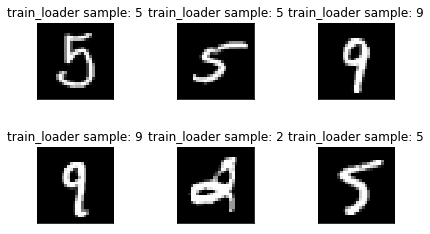

In [8]:
#observe dataset sample 
x, y = next(iter(train_loader))
print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
plot_image(x, y, "train_loader sample")

In [9]:
#use GPU
device = torch.device("cuda:0")

In [23]:
#train lenet model
model = lenet().to(device)
#observe model structure
print(model)

after conv unit:  torch.Size([2, 32, 5, 5])
before full connect unit:  torch.Size([2, 800])
after full connect unit:  torch.Size([2, 10])
lenet(
  (conv_unit): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_unit): Sequential(
    (0): Linear(in_features=800, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)


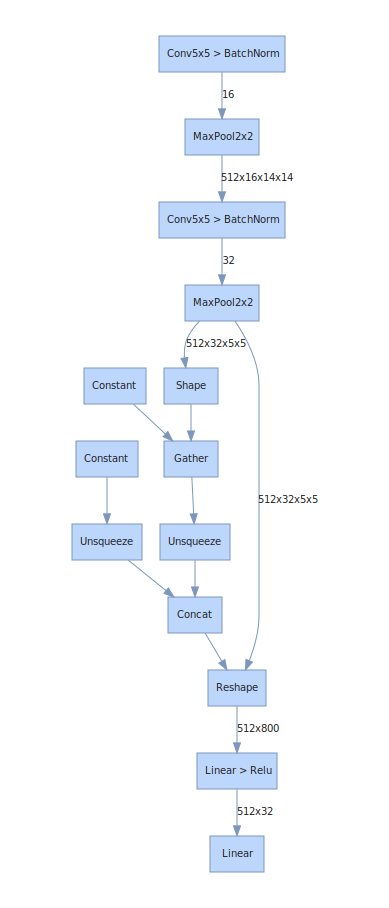

In [24]:
# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([512, 1, 28, 28]).to(device))
# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

In [25]:
#loss function 
criterion = nn.CrossEntropyLoss().to(device)

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [27]:
#initalize visdom
viz = Visdom()

viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss'))
viz.line([0.], [0.], win='test_loss', opts=dict(title='test loss'))
viz.line([0.], [0.], win='test_acc', opts=dict(title='test acc.'))

'test_acc'

In [28]:
global_step = 0

for epoch in range(epochs):
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #use gpu to caluate
        data, target = data.to(device), target.to(device)
        #train
        logits = model(data)
        loss = criterion(logits, target)
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1
        viz.line([loss.item()], [global_step], win='train_loss', update='append')
        
    print(epoch, 'loss:', loss.item())
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            #run
            logits = model(data)
            loss = criterion(logits, target).item()
            test_loss += loss
            pred = logits.argmax(dim=1)
            #
            correct = torch.eq(pred, target).sum().item()
            total_correct += correct
        
        acc = total_correct / len(test_loader.dataset)
        
        viz.line([test_loss], [global_step], win='test_loss', update='append')
        viz.line([acc], [global_step], win='test_acc', update='append')    
        
        print(epoch, "acc: ", acc)

0 loss: 0.20452278852462769
0 acc:  0.9505
1 loss: 0.17165029048919678
1 acc:  0.9707
2 loss: 0.14492027461528778
2 acc:  0.9767
3 loss: 0.056027065962553024
3 acc:  0.9774
4 loss: 0.04900920018553734
4 acc:  0.9806
5 loss: 0.05872320011258125
5 acc:  0.9832
6 loss: 0.03516030311584473
6 acc:  0.9831
7 loss: 0.06490133702754974
7 acc:  0.9845
8 loss: 0.041867971420288086
8 acc:  0.985
9 loss: 0.05373447760939598
9 acc:  0.9844


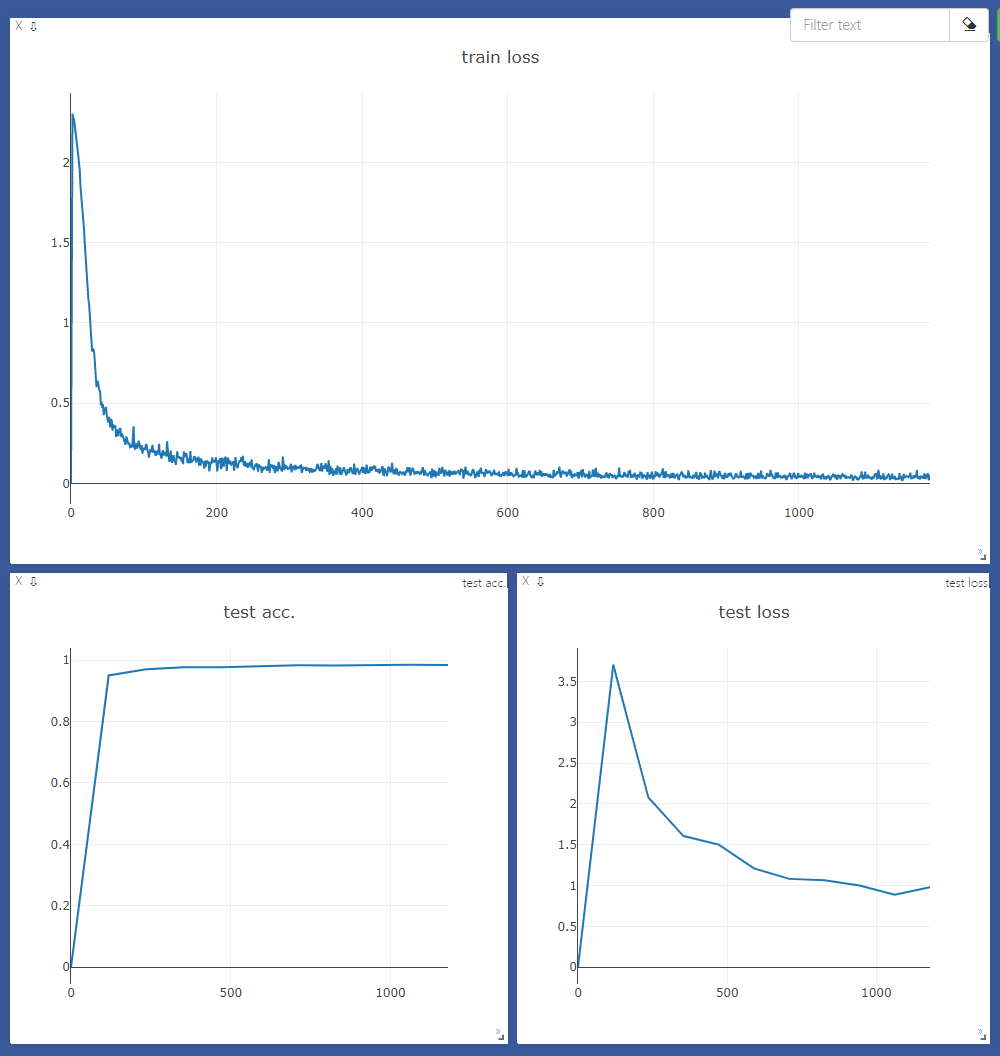